In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from typing import Tuple, Optional

# cuda available?
print(torch.cuda.is_available())

fname = "input.txt"
with open(fname, "r") as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"{vocab_size=}")
print(f"{chars[0]=}")

/Users/dan/.dan/projects/playground/AI/danoGPT/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:20: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:84.)
  device: torch.device = torch.device(torch._C._get_default_device()),  # torch.device('cpu'),


False
vocab_size=65
chars[0]='\n'


In [2]:
# simple tokenizer
# string to int
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[n] for n in l])

res = encode("hello world")
print(res)
print(decode(res))

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
hello world


In [3]:
# let's tokenize our dataset

all_data = torch.tensor(encode(text), dtype=torch.long)
print(f"full dataset: {all_data.shape=}, {all_data.dtype=}")
print(f"{all_data[:50]=}")

print(decode(all_data[:50].tolist()))


def split_dataset(
    data: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Split"""
    n = len(data)
    s1 = int(n * 0.8)
    s2 = int(n * 0.9)
    return (data[:s1], data[s1:s2], data[s2:])


train_data, val_data, test_data = split_dataset(all_data)
data_map = {
    "train": train_data,
    "test": test_data,
    "val": val_data,
}
print(f"{len(train_data)/len(all_data)=:.4f}")
print(f"{len(val_data)/len(all_data)=:.4f}")
print(f"{len(test_data)/len(all_data)=:.4f}")

full dataset: all_data.shape=torch.Size([1115394]), all_data.dtype=torch.int64
all_data[:50]=tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56])
First Citizen:
Before we proceed any further, hear
len(train_data)/len(all_data)=0.8000
len(val_data)/len(all_data)=0.1000
len(test_data)/len(all_data)=0.1000


In [4]:
# block size of 8 (containining 9 tokens)
#   means there are 8 challenges to solve
#   e.g. given token 0 predict token 1, given [0,1] predict 2, ...
block_size = 8
train_data[: block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
seed = 1337
torch.manual_seed(seed)
batch_size = 4  # num independent sequences to process in parallel
block_size = 8  # max context length for predictions


def get_batch(
    split: str, batch_size: int = batch_size, block_size: int = block_size
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Produce batch of inputs and target sequences.
    E.g. for a given batch item, x[item]: "hello wo",  y[item]: "ello wor",
    # so later input "h" -> target "e", input "he" -> "l", input "hel" -> "o", ...
    x and y both have dimensions: (batch_size, block_size)
    """
    data = data_map[split]

    # print(f"generating random int in [0, {len(data) - block_size})")
    # generate random start index batch_size separate batches
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[(i + 1) : i + block_size + 1] for i in ix])
    return x, y


xb, yb = get_batch("train")
print(f"{xb.shape=}")  # inputs: (4, 8)
print(f"{yb.shape=}")  # target: (4, 8)

# for example
print(f"inputs: '{decode(xb[0].tolist())}'")
print(f"target: '{decode(yb[0].tolist())}'")

xb.shape=torch.Size([4, 8])
yb.shape=torch.Size([4, 8])
inputs: 'ty.

GLO'
target: 'y.

GLOU'


In [20]:
# (22:45 in tutorial)

class BigramLangModel(nn.Module):
    def __init__(self, vocab_size: int):
        super().__init__()

        # in this case, embeddings have the same length as the vocab size
        # because for a bigram model, one char should map to a probability distribution of the other chars :)
        num_embeddings = vocab_size
        embedding_dim = vocab_size
        self.token_embedding_table = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, idx: torch.Tensor, targets: Optional[torch.Tensor] = None):
        """idx and target are both (B,T) tensor of integers."""

        # map tokens to their embeddings
        logits = self.token_embedding_table(idx)

        B, T, C = logits.shape

        if targets is None:
            return logits, None

        # restructure for cross_entropy function
        logits = logits.view((B * T, C))
        targets = targets.view(B * T)
        # reorder (B,T,C) -> (B,C,T)
        loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx: torch.Tensor, max_new_tokens: int):
        """
        Given context (idx tokens), predict max_new_tokens.
        idx is (B,T) of indieces in current context.
        """

        for _ in range(max_new_tokens):
            logits, _ = self(idx)  # predict
            # print(f"{logits.shape=}")
            # this is a bigram model, so only need to look at last context token (-1)
            logits = logits[:, -1, :]  # (B,C)
            # print(f"{logits.shape=}")

            probs = F.softmax(logits, dim=-1)  # (B,C)
            # sample from dist
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


model = BigramLangModel(vocab_size)
logits, loss = model(xb, yb)
print(f"{loss=:.4f}")
# batch, time (block_size), channel (embedding_dim)
print(f"{logits.shape=}")  # (B=4, T=8, C=65)

# generate text starting with newline char
idx = torch.ones((1, 1), dtype=torch.long).fill_(encode("\n")[0])
print(f"{idx=}")
print(f"{type(idx)=}")
res = model.generate(idx, 25)
print(res.shape)
text = decode(res[0].tolist())

print(f"text='{text}'")

def eval_model(split: str):
    """return average loss across "some part" of a given dataset split (e.g. 'val')."""
    total_loss = 0.0
    samples = 100
    with torch.no_grad():
        for _ in range(samples):
            xb, yb = get_batch(split, batch_size=8, block_size=100)
            _, loss = model(xb, yb)
            total_loss += loss
    return total_loss.item() / samples

eval_0 = eval_model("val")
print(f"{eval_0=:.4f}")


loss=4.6686
logits.shape=torch.Size([800, 65])
idx=tensor([[0]])
type(idx)=<class 'torch.Tensor'>
torch.Size([1, 26])
text='
laJqLS!lV
vyDSdqSdDJhJ-Nv'
eval_0=4.6655


In [29]:
from tqdm import tqdm
# higher learning rate cause this network is tiny
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

stats = {"val": [], "train": [], "step": []}

text_before = decode(model.generate(idx, 25)[0].tolist())
print(f"{text_before=}")

for step in tqdm(range(10000)):
    if step % 100 == 0:
        stats["step"].append(step)
        stats["val"].append(eval_model("val"))
        stats["train"].append(eval_model("train"))
    
    xb, yb = get_batch("train", batch_size=8, block_size=500)
    model.train()
    optimizer.zero_grad()
    _, loss = model(xb, yb)
    loss.backward()
    optimizer.step()


print(stats)



    

text_before='\n:LELOLAymyk!\n:XKnWfw f ae'


 96%|█████████▋| 9650/10000 [02:25<00:05, 66.39it/s]


KeyboardInterrupt: 


ENI t thag.
Whe I f rnecoof sim d bithis feal,
LOLart e ilol hased h ng?
S:
K:
Wh. ofulontteBee usthark'lot I, an'sperthancrtPUK:

Theimarer' lano fr an ht otha tou thedingath I t hanghetid sis y,
bear, t s?
t
Core t.
Mys digifo!--wstenof and h m an, ivems ck s fe tund e, ad ut de.
Whyorin tls or pr yokn:
TERKI mungoum!'l f br,
EREThe may,

I:
astonony st

As beade BO helse.
OHeverse mbist t;
NThagey d.

ARinyeny sis ome
Yo k' t th I this hed brernd
Whes d urrro r t; te bbeay s
Whusof;'t th;

S:


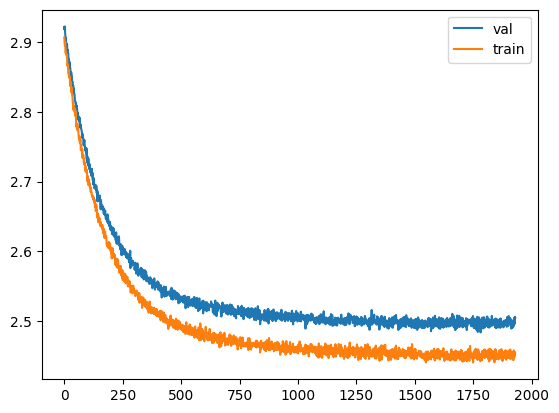

In [34]:
# generate text starting with newline char
idx = torch.ones((1, 1), dtype=torch.long).fill_(encode("\n")[0])
text_after = decode(model.generate(idx, 500)[0].tolist())
#print(f"{text_after=}")
print(text_after)

# plot stats
import matplotlib.pyplot as plt

# val and train on sample plot
plt.plot(stats["val"], label="val")
plt.plot(stats["train"], label="train")
plt.legend()
plt.show()